In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import lime
import lime.lime_tabular
import shap
from sklearn.naive_bayes import GaussianNB
from scipy.stats import norm, spearmanr, pearsonr
from sklearn.metrics.pairwise import cosine_similarity, kernel_metrics
from sklearn.metrics import log_loss
import matplotlib
from sklearn.metrics import accuracy_score
from tabulate import tabulate
import sys
sys.path.append('../')
import scipy
from sklearn.preprocessing import KBinsDiscretizer
#import scikit_posthocs
from techniques import get_local_permutation_importance, get_lime_explanations, get_shap_explanations, nbayes_local_explaination, lreg_local_explaination
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
import pickle
import os
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import pandas as pd

In [4]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if type(X) == scipy.sparse.csr.csr_matrix:    
            return X.todense()
        else: 
            return X

In [5]:
sys.path.append('../tabular/')
from get_all_explanations import lime_exp, shap_exp, lpi_exp, ground_truth

In [11]:
exp_colors = ['#C4A705', '#E97439', '#65ED99']
flierprops = {'lime': dict(marker='o', markeredgecolor='#D7191C'),
              'shap': dict(marker='o', markeredgecolor='#2C7BB6'),
              'lpi': dict(marker='o', markeredgecolor='#008000')}

boxprops = dict(linestyle='-', linewidth=1.5)

In [7]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], facecolor=color, linewidth=1.5)
    plt.setp(bp['medians'], color='black', linewidth=1.5)
    plt.setp(bp['fliers'], color=color, markerfacecolor=color, markeredgecolor='black', linewidth=1.5)

## Single chart 

In [12]:
exp_colors = ['#C4A705', '#E97439', '#65ED99']
e_names = [ 'lime', 'shap','lpi']
e_names_alt = ['LIME', 'SHAP', 'LPI']

[0.88 0.88 0.8  0.88 0.85 0.92 0.82 0.88 0.98]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

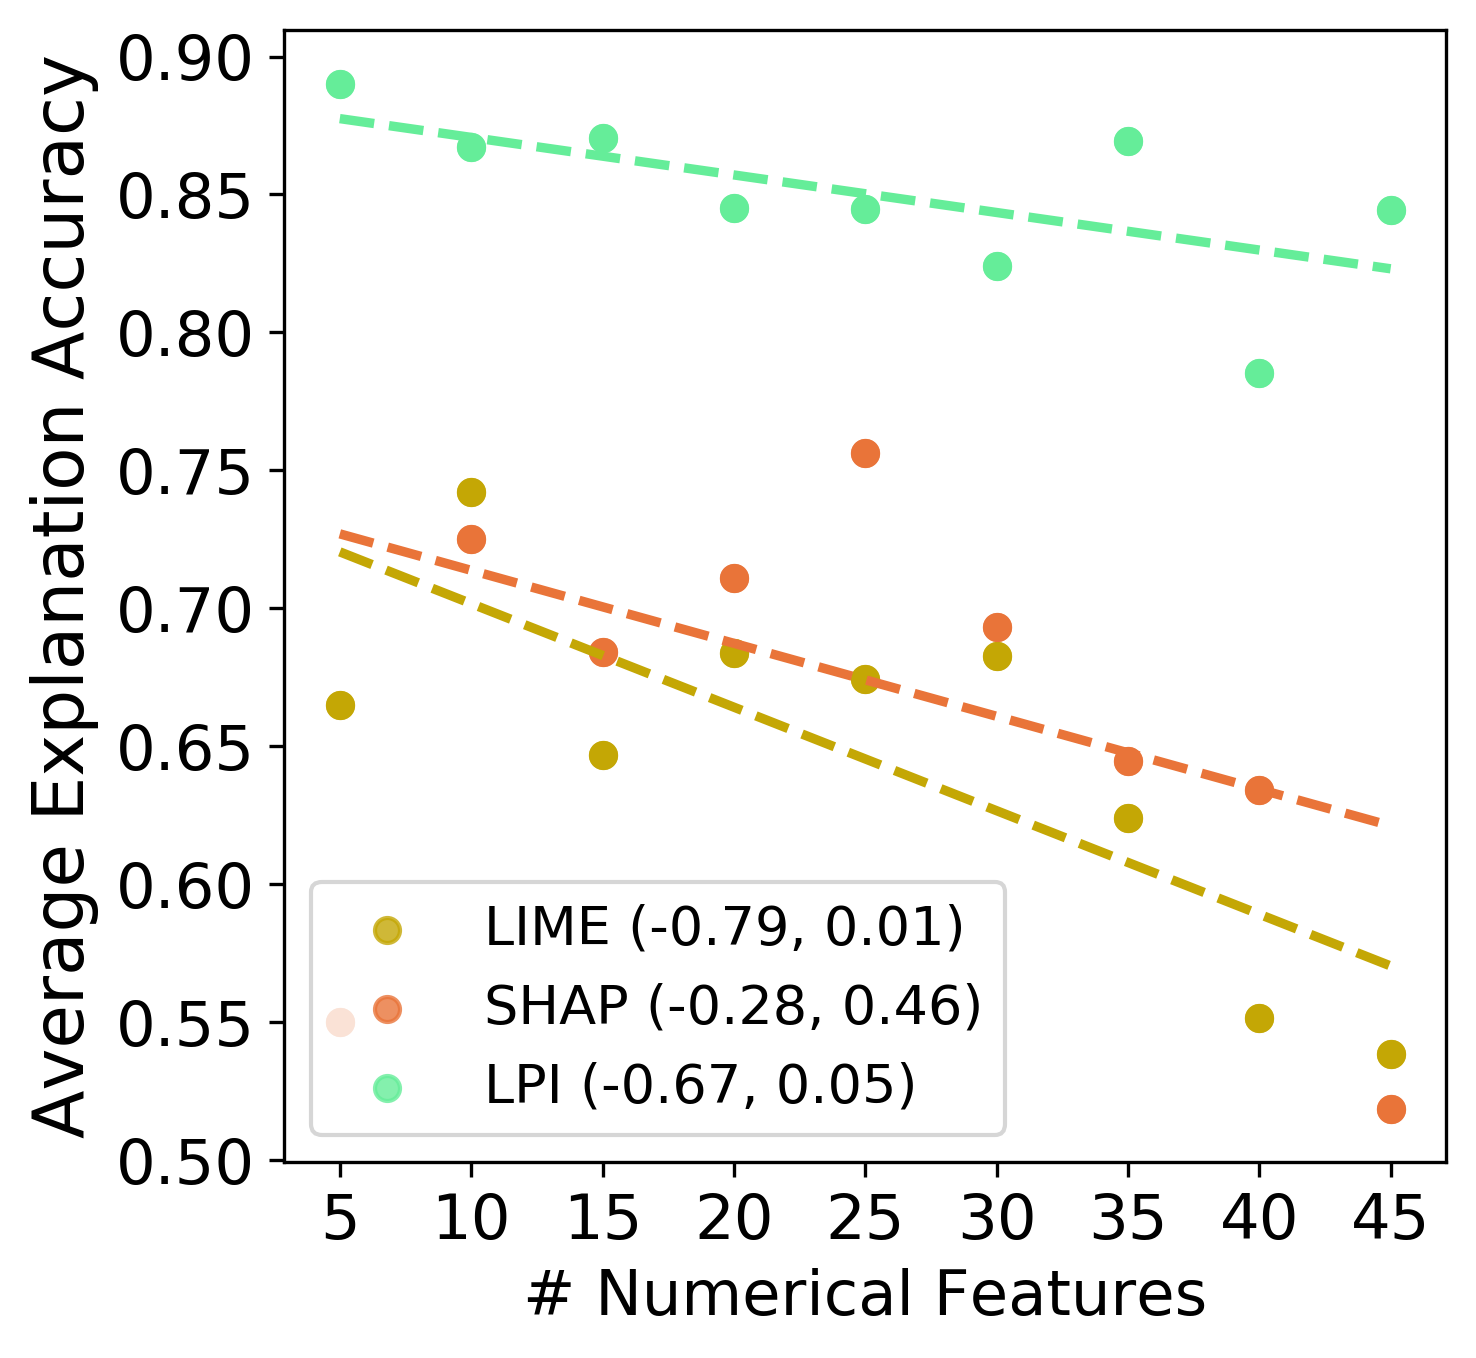

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True, dpi=300)
offset = [0, 0.2, -0.2]

model_name = 'gbayes'

if model_name == 'lr':
    #Num
    gts = pickle.load( open( "./gt_regresion_numeric_all.p", "rb" ) )
    exps = pickle.load( open( "./exps_regresion_numeric_all.p", "rb" ) )
    accuracy_scores = pickle.load( open( "./accuracy_regresion_numeric_all.p", "rb" ) )[model_name]
    number_of_features = np.arange(5, 50, 5)
    #Cat
    #gts = pickle.load( open( "./gt_regresion_all.p", "rb" ) )
    #exps = pickle.load( open( "./exps_regresion_all.p", "rb" ) )
    #accuracy_scores = pickle.load( open( "./accuracy_regresion_all.p", "rb" ) )[model_name]
    #number_of_features = np.arange(0, 35, 5)
else:
    # Num 
    gts = pickle.load( open( "./gt_all_numeric.p", "rb" ) )
    exps = pickle.load( open( "./exps_all_numeric.p", "rb" ) )
    accuracy_scores = pickle.load( open( "./accuracy_scores_all_numeric.p", "rb" ) )[model_name]
    number_of_features = np.arange(5, 50, 5)

    # Cat
    #gts = pickle.load( open( "./gt_all.p", "rb" ) )
    #exps = pickle.load( open( "./exps_all.p", "rb" ) )
    #accuracy_scores = pickle.load( open( "./accuracy_scores_all.p", "rb" ) )[model_name]
    #number_of_features = np.arange(0, 35, 5)


ticks = []
print(np.round(accuracy_scores, 2).astype(float))
for h in range(len(number_of_features)):
    ticks.append('{}'.format(number_of_features[h]))

pos = np.arange(0, len(number_of_features))

for k in range(len(e_names)):
        all_result = []
        for i in range(len(number_of_features)):
            temp = []
            for j in range(len(gts[i][model_name])):
                temp.append(spearmanr(np.abs(gts[i][model_name][j]), np.abs(exps[i][model_name][e_names[k]][j])).correlation)

            all_result.append(np.nanmean(temp))
                
        corr_val = pearsonr(pos, all_result)
        ax.scatter(pos, all_result, color=exp_colors[k])
        #ax.plot(pos, all_result, label='{} ({}, {})'.format(e_names_alt[k], corr_val[0].round(2), corr_val[1].round(2)), linestyle='--', color=exp_colors[k])
        g = sns.regplot(pos, all_result,  robust=True, logx=False, 
                        color=exp_colors[k], label='{} ({}, {})'.format(e_names_alt[k], corr_val[0].round(2), corr_val[1].round(2)), 
                        ax=ax, line_kws={'linestyle':'--'}, ci=None)

#ax1 = ax.twinx()
#sns.regplot(pos, accuracy_scores, color='#85A1F2', label='Model Accuracy', ci=None, ax=ax1, line_kws={'linestyle':'--'})

ax.set_xticks(np.arange(len(ticks)))
ax.set_xticklabels(ticks, fontsize=15)
ax.set_ylabel('Average Explanation Accuracy', fontsize=17)
#ax.set_xlabel('# Categorical Features', fontsize=17)
ax.set_xlabel('# Numerical Features', fontsize=15)
ax.yaxis.set_tick_params(labelsize=15)

#ax[2].plot(ticks, accu[m_names[l]], c='#A8B5E0', label='Model Accuracy', linestyle='-', marker='x')

ax.legend(prop={'size': 13})  
#ax1.set_ylabel('Model Accuracy')
#ax1.legend()
#plt.savefig('./factor_cat_{}.eps'.format(model_name), bbox_inches='tight')
plt.savefig('./factor_num_{}.eps'.format(model_name), bbox_inches='tight')
plt.show()

Mean of empty slice
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.

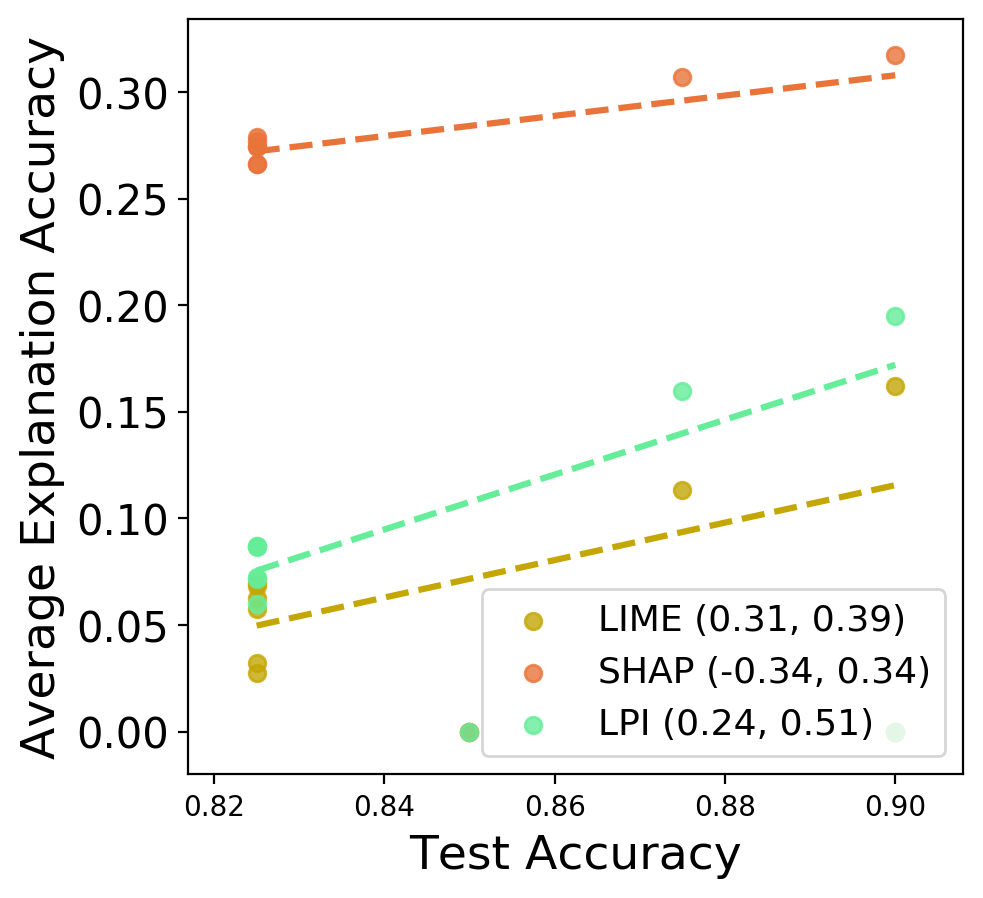

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharey=True, dpi=200)
offset = [0, 0.2, -0.2]
from functools import partial
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
model_name = 'lreg'

if model_name == 'lr':
    gts = pickle.load( open( "./gt_generalization_regresion_all.p", "rb" ) )
    exps = pickle.load( open( "./exps_generalization_regresion_all.p", "rb" ) )
    accuracy_scores_ = pickle.load( open( "./generalization_regression_accuracy_scores.p", "rb" ))[model_name]
    accuracy_scores_ = np.log(accuracy_scores_)
    #accuracy_scores_ = np.reciprocal(accuracy_scores_)
else:
    gts = pickle.load( open( "./gt_all_generalization.p", "rb" ) )
    exps = pickle.load( open( "./exps_all_generalization.p", "rb" ) )
    accuracy_scores_ = pickle.load( open( "./generalization_accuracy_scores.p", "rb" ))[model_name]
    

#num_features = np.arange(5, 50, 5)
#num_feat_bin = np.arange(0, 35, 5)

ticks = []

for h in range(10):
    ticks.append('{}'.format(accuracy_scores_[h]))

#for h in range(len(num_features)):
#    ticks.append('{}'.format(num_features[h]))


for k in range(len(e_names)):
        #all_result[e_name[k]] = []
        all_result = []
        for i in range(10):
        #for i in range(len(num_feat_bin)):
        #for i in range(len(num_features)):
            temp = []
            for j in range(len(gts[i][model_name])):
                temp.append(spearmanr(np.abs(gts[i][model_name][j]), np.abs(exps[i][model_name][e_names[k]][j])).correlation)

            all_result.append(np.nanmean(temp))
        
        #pos = np.arange(0, len(num_feat_bin))
        #pos = np.arange(0, len(num_features))
        all_result = np.nan_to_num(all_result)
        corr_val = pearsonr(accuracy_scores_, all_result)
        #ax.scatter(accuracy_scores_, all_result, color=exp_colors[k], label='{} ({}, {})'.format(e_names_alt[k], corr_val[0].round(2), corr_val[1].round(2)))
        g = sns.regplot(accuracy_scores_, all_result,  robust=True, logx=False, 
                        color=exp_colors[k], label='{} ({}, {})'.format(e_names_alt[k], corr_val[0].round(2), corr_val[1].round(2)), 
                        ax=ax, line_kws={'linestyle':'--'}, ci=None)
        #ax.set_xscale('symlog')
        #g.set(xscale='log')
        if model_name == 'lr':
            locmin = mticker.LogLocator(base=10, subs=np.linspace(np.min(accuracy_scores_),np.max(accuracy_scores_), 2), numticks=5)  
            g.axes.xaxis.set_minor_locator(locmin)
        
        #ax.set(xticks=np.linspace(np.min(accuracy_scores_).round(2),np.max(accuracy_scores_).round(2), 4))  #limit the number of ticks to 4
        #ax.set_xticklabels(['Cond1','Cond2','Cond3', "Cond4"]) #rename ticks 
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        #ax.plot(accuracy_scores_, all_result, label='{} ({}, {})'.format(e_names_alt[k], corr_val[0].round(2), corr_val[1].round(2)), linestyle='--', color=exp_colors[k])
        
#ax.set_xticks(np.arange(np.min(accuracy_scores_), np.max(accuracy_scores_)))
#ax.set_xticklabels(ticks, fontsize=15)

ax.set_ylabel('Average Explanation Accuracy', fontsize=17)
if model_name == 'lr':
    ax.set_xlabel('Test Error (Log)', fontsize=17)
else:
    ax.set_xlabel('Test Accuracy', fontsize=17)

#ax.set_xlabel('# Numerical Features', fontsize=15)

ax.yaxis.set_tick_params(labelsize=15)
#ax.ticklabel_format(axis='x', style='sci', scilimits=(4,4))
#ax[2].plot(ticks, accu[m_names[l]], c='#A8B5E0', label='Model Accuracy', linestyle='-', marker='x')

ax.legend(prop={'size': 13})  

plt.savefig('./gen_factor_{}.eps'.format(model_name), bbox_inches='tight')
plt.show()

In [21]:
d_info = {}
random_state = 0
num_feat_bin = [4]

i = 0

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if type(X) == scipy.sparse.csr.csr_matrix:    
            return X.todense()
        else: 
            return X

redundant = int(np.round(0.2* (40 - num_feat_bin[i])))
X, y = make_classification(
    n_features=40, n_redundant=redundant, n_clusters_per_class=2, random_state=0
)


d_info[i] = {'features': [], 'cat_feature_name': [], 'cat_feature_idx': []}

est = KBinsDiscretizer(n_bins=4, encode='onehot', strategy='uniform')
one_hot_data = est.fit_transform(X[:, -num_feat_bin[i]:]).toarray()
not_one_hot = np.arange(0, 40 - num_feat_bin[i])
X = np.append(X[:, not_one_hot], one_hot_data, axis=1)

cat_feature_idx = np.setxor1d(np.arange(X.shape[1]), not_one_hot)

d_info[i]['cat_feature_idx'] = cat_feature_idx
d_info[i]['cat_feature_name'] = cat_feature_idx

for cat in cat_feature_idx: 
    enc = LabelEncoder()
    X[:,cat] = enc.fit_transform(X[:, cat])

features = []
for k in range(X.shape[1]):
    features.append('Feature {}'.format(k))
d_info[i]['features'] = features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)


In [22]:
def get_random_params(model_name):
    hyperparams = {
        'lreg': {
            'penalty': ['l1', 'l2'], 
            'C': [0.01, 0.1, 0.5, 1, 2],
            'max_iter': [1000, 2000, 10000],
            'solver': ['saga']
        },
        'gbayes': {
            'priors': [[0.3, 0.7], [0.5, 0.5], None],
            'var_smoothing': [0, 0.1, 0.2, 0.01]
        }   
    } 
    
    params = {}
    for h in hyperparams[model_name]:
        vals = hyperparams[model_name][h]
        sel = np.random.choice(vals, 1)[0]
        params[h] = sel
    return params

In [23]:
exp_function = {
        'lime': lime_exp,
        'shap': shap_exp,
        'lpi': lpi_exp,
    }

In [24]:
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [25]:
accuracy_scores_ = {'lreg': [], 'gbayes': []}
gts = {}
exps = {}

#for i in range(10):
for i in range(2):
    gts[i] = {'lreg': [], 'gbayes': []}
    exps[i] = {'lreg': {'lpi': [], 'lime': [], 'shap': []}, 'gbayes': {'lpi': [], 'lime': [], 'shap': []}}
    
    params = get_random_params('lreg')
    categorical_encoder_lreg = OneHotEncoder(handle_unknown="ignore")
    preprocessing_lreg = ColumnTransformer([
        ("cat", categorical_encoder_lreg, cat_feature_idx)], remainder='passthrough')
    lreg = Pipeline([
        ("preprocess", preprocessing_lreg),
        ('to_dense', DenseTransformer()), 
        ("lreg", LogisticRegression(**params))
    ])
    
    lreg.fit(X_train, y_train)
    accuracy_scores_['lreg'].append(accuracy_score(y_test, lreg.predict(X_test)))
    
    params = get_random_params('gbayes')
    categorical_encoder_gb = OneHotEncoder(handle_unknown="ignore")    
    preprocessing_gb = ColumnTransformer([
        ("cat", categorical_encoder_gb, cat_feature_idx)], remainder='passthrough')
    gbayes = Pipeline([
        ("preprocess", preprocessing_gb),
        ('to_dense', DenseTransformer()), 
        ("gbayes", GaussianNB(**params))
    ])
    
    
    gbayes.fit(X_train, y_train)
    accuracy_scores_['gbayes'].append(accuracy_score(y_test, gbayes.predict(X_test)))
    
    
    features = np.array(features)
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train,  feature_names = features, verbose=False, mode='classification', discretize_continuous=False)
    
    #for j in range(len(X_test)):
    #for j in range(1):
        gts[i]['gbayes'].append(ground_truth(X_test[j], X_train, d_info, gbayes, 0, 'gbayes'))
        gts[i]['lreg'].append(ground_truth(X_test[j], X_train, d_info, lreg, 0, 'lreg'))
        
        
    for e_names in exp_function.keys():
        for j in range(len(X_test)):
        #for j in range(1):
            exps[i]['lreg'][e_names].append(exp_function[e_names](X_test[j], X_train, d_info, lreg, 0, 'lreg'))
            exps[i]['gbayes'][e_names].append(exp_function[e_names](X_test[j], X_train, d_info, gbayes, 0, 'gbayes'))

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [49]:
gts = pickle.load( open( "./gt_all_generalization.p", "rb" ) )
exps = pickle.load( open( "./exps_all_generalization.p", "rb" ) )

In [56]:
gts = pickle.load( open( "./gt_generalization_regresion_all.p", "rb" ) )
exps = pickle.load( open( "./exps_generalization_regresion_all.p", "rb" ) )

In [58]:
gts[0]['lr'][0]

array([  9.40313129,  -0.        ,  -4.45018381,   0.        ,
         0.        ,  -4.6452936 , -13.41109843,   0.        ,
        -1.90642868,  28.57572032,  -0.        ,   0.        ,
        -3.51401557, -33.99616457,   0.        ,  12.61451308,
        -0.        ,  15.54679089,  -0.        ,  -0.        ,
        14.66171972, -17.31244162,   0.        ,  21.9304812 ,
        -0.        ,  -0.        ,  -1.28351156, -18.53261134,
         0.        ,  -8.49423878,   0.        ,  33.54872309,
         2.41278822,   3.80137292,  -1.59385772,  -4.31367848,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [64]:
exps[0]['lr']['lime'][0].shape

(52,)